In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# 이전에 형태소 분리한 문장 불러오기

In [3]:
X_morphs = np.load('/gdrive/My Drive/Colab Notebooks/X_morph.npy', allow_pickle=True)

In [4]:
y_org = np.load('/gdrive/My Drive/Colab Notebooks/y_org.npy', allow_pickle=True)

In [5]:
X_morphs

array([list(['언니', '동생', '부르다', '맞다', '일', '인가요', '?', '.']),
       list(['그냥', '내', '느낌', '일', '뿐', '겠다', '?']),
       list(['아직', '너무', '초기', '라서', '그런', '거', '죠', '?']), ...,
       list(['공장', '도시락', '비우다', '생', '적임', '아르바이트', '화장실', '가성', '손', '않씯', '재료', '담다', '바닥', '떨어지다', '줍다', '담다', '그렇다']),
       list(['코딱지', '만', '나라', '에서', '지다', '들다', '끼리', '피터지다', '싸우다', '세다', '징', '클래스', 'ㅉㅉㅉ']),
       list(['와이프', '그렇다', '댓글', '보다', '이휘재', '하차', '하라', '전', '해주다'])],
      dtype=object)

In [6]:
y_org

array(['공포', '공포', '공포', ..., '혐오', '혐오', '혐오'], dtype=object)

# train-test split

In [7]:
from sklearn.model_selection import train_test_split
X_, X_test, y_, y_test = train_test_split(X_morphs, y_org, 
                                          test_size=0.3, 
                                          random_state=777, 
                                          stratify=y_org)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_, y_, 
                                                  test_size=0.1, 
                                                  random_state=777,
                                                  stratify=y_)

In [9]:
np.unique(y_test, return_counts=True)

(array(['공포', '놀람', '분노', '슬픔', '중립', '행복', '혐오'], dtype=object),
 array([1638, 1766, 1699, 1573, 1448, 1801, 1628]))

# 레이블 원핫 인코딩

In [10]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
y_train = enc.fit_transform(y_train)
y_val = enc.transform(y_val)
y_test = enc.transform(y_test)

In [11]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [12]:
y_train.shape

(24260, 7)

In [13]:
y_val.shape

(2696, 7)

In [14]:
y_test.shape

(11553, 7)

# 정수 인코딩

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [16]:
threshold = 2
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0 

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합 크기 :',total_cnt)
print('출현빈도가 %s번 미만 단어 수: %s'%(threshold, rare_cnt))
print("희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합 크기 : 19028
출현빈도가 2번 미만 단어 수: 9381
희귀 단어의 비율: 49.301030060962795
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.9930541140402696


In [17]:
voca_threshold = total_cnt - rare_cnt + 1
voca_threshold

9648

In [18]:
tokenizer2 = Tokenizer(voca_threshold)
tokenizer2.fit_on_texts(X_train)
X_train = tokenizer2.texts_to_sequences(X_train)
X_val = tokenizer2.texts_to_sequences(X_val)
X_test = tokenizer2.texts_to_sequences(X_test)

In [19]:
X_train[:5]

[[665, 118],
 [1619, 4, 2, 1025, 469],
 [29, 174, 46, 355, 2],
 [1470, 128, 27, 12],
 [44, 1708, 3049, 8, 2, 7, 102]]

In [20]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [21]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [22]:
print(X_train.shape)
print(y_train.shape)

(24249,)
(24249, 7)


# 패딩

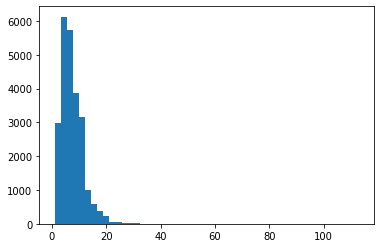

In [23]:
plt.hist([len(s) for s in X_train], bins=50)
plt.show()

In [24]:
max(len(l) for l in X_train)

113

In [25]:
max_len = 30

In [26]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [27]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_val = pad_sequences(X_val, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [28]:
X_train[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,  665,  118],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0, 1619,    4,    2, 1025,  469],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,   29,  174,   46,  355,    2],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0, 1470,  128,   27,   12],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,   44, 1708, 3049, 

# LSTM _ 기본 Embedding()

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [30]:
vocab_size = voca_threshold
embedding_dim = 128
hidden_units = 128
num_classes = 7

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

In [31]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [32]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [33]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, callbacks=[es, mc], validation_data=(X_val, y_val))

Epoch 1/10
190/190 [==============================] - 28s 135ms/step - loss: 1.5935 - acc: 0.3852 - val_loss: 1.4008 - val_acc: 0.4484

Epoch 00001: val_acc improved from -inf to 0.44844, saving model to best_model.h5
Epoch 2/10
190/190 [==============================] - 26s 137ms/step - loss: 1.2041 - acc: 0.5416 - val_loss: 1.3648 - val_acc: 0.4744

Epoch 00002: val_acc improved from 0.44844 to 0.47441, saving model to best_model.h5
Epoch 3/10
190/190 [==============================] - 27s 140ms/step - loss: 1.0021 - acc: 0.6254 - val_loss: 1.4594 - val_acc: 0.4670

Epoch 00003: val_acc did not improve from 0.47441
Epoch 4/10
190/190 [==============================] - 26s 139ms/step - loss: 0.8275 - acc: 0.7020 - val_loss: 1.5437 - val_acc: 0.4518

Epoch 00004: val_acc did not improve from 0.47441
Epoch 5/10
190/190 [==============================] - 26s 138ms/step - loss: 0.6887 - acc: 0.7563 - val_loss: 1.7111 - val_acc: 0.4418

Epoch 00005: val_acc did not improve from 0.47441
Epo

In [34]:
loaded_model = load_model('best_model.h5')
print(loaded_model.evaluate(X_test, y_test)[1])

362/362 [==============================] - 5s 13ms/step - loss: 1.3416 - acc: 0.4864
0.4863671660423279


# BiLSTM

In [35]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [36]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units)))
model.add(Dense(7, activation='softmax'))

In [37]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [38]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_data=(X_val, y_val))

Epoch 1/15
95/95 [==============================] - 39s 372ms/step - loss: 1.7273 - acc: 0.3363 - val_loss: 1.5033 - val_acc: 0.4080

Epoch 00001: val_acc improved from -inf to 0.40801, saving model to best_model.h5
Epoch 2/15
95/95 [==============================] - 34s 353ms/step - loss: 1.3805 - acc: 0.4683 - val_loss: 1.4137 - val_acc: 0.4525

Epoch 00002: val_acc improved from 0.40801 to 0.45252, saving model to best_model.h5
Epoch 3/15
95/95 [==============================] - 34s 360ms/step - loss: 1.2459 - acc: 0.5222 - val_loss: 1.3760 - val_acc: 0.4618

Epoch 00003: val_acc improved from 0.45252 to 0.46180, saving model to best_model.h5
Epoch 4/15
95/95 [==============================] - 34s 361ms/step - loss: 1.1468 - acc: 0.5665 - val_loss: 1.3736 - val_acc: 0.4707

Epoch 00004: val_acc improved from 0.46180 to 0.47070, saving model to best_model.h5
Epoch 5/15
95/95 [==============================] - 35s 369ms/step - loss: 1.0559 - acc: 0.6029 - val_loss: 1.4223 - val_acc: 0

In [39]:
loaded_model = load_model('best_model.h5')
print(loaded_model.evaluate(X_test, y_test)[1])

362/362 [==============================] - 8s 20ms/step - loss: 1.3466 - acc: 0.4867
0.4867134094238281


# Word 2 Vec

In [41]:
from sklearn.model_selection import train_test_split
X_, X_test, y_, y_test = train_test_split(X_morphs, y_org, 
                                          test_size=0.3, 
                                          random_state=777, 
                                          stratify=y_org)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, 
                                                  test_size=0.1, 
                                                  random_state=777,
                                                  stratify=y_)

In [42]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
y_train = enc.fit_transform(y_train)
y_val = enc.transform(y_val)
y_test = enc.transform(y_test)

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [43]:
from gensim.models import Word2Vec
w2v = Word2Vec(sentences=X_train, size=100, window=5, min_count=3, workers=4, sg=0)

In [44]:
def embedding(X, wv):
  embed_dim = 100
  pad_num = 30
  pad_vec = [0 for j in range(100)]
  ret = []
  for sent in X:
    newsent = []
    for i in range(pad_num):
      try:
        newsent.append(wv[sent[i]])
      except:
        newsent.append(pad_vec)
    ret.append(newsent)
  return np.array(ret)

In [45]:
X_train_embed = embedding(X_train, w2v.wv)

In [46]:
X_train_embed.shape

(24260, 30, 100)

In [47]:
X_val_embed = embedding(X_val, w2v.wv)
X_test_embed = embedding(X_test, w2v.wv)

In [48]:
hidden_units = 128
num_classes = 7

model = Sequential()
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])


In [49]:
history = model.fit(X_train_embed, y_train, batch_size=128, epochs=10, callbacks=[es, mc], 
                    validation_data=(X_val_embed, y_val))

Epoch 1/10
190/190 [==============================] - 24s 112ms/step - loss: 1.9184 - acc: 0.1866 - val_loss: 1.8129 - val_acc: 0.2493

Epoch 00001: val_acc improved from -inf to 0.24926, saving model to best_model.h5
Epoch 2/10
190/190 [==============================] - 21s 110ms/step - loss: 1.8283 - acc: 0.2424 - val_loss: 1.8122 - val_acc: 0.2522

Epoch 00002: val_acc improved from 0.24926 to 0.25223, saving model to best_model.h5
Epoch 3/10
190/190 [==============================] - 21s 109ms/step - loss: 1.8062 - acc: 0.2589 - val_loss: 1.7605 - val_acc: 0.2871

Epoch 00003: val_acc improved from 0.25223 to 0.28709, saving model to best_model.h5
Epoch 4/10
190/190 [==============================] - 21s 109ms/step - loss: 1.7489 - acc: 0.2975 - val_loss: 1.7023 - val_acc: 0.3223

Epoch 00004: val_acc improved from 0.28709 to 0.32233, saving model to best_model.h5
Epoch 5/10
190/190 [==============================] - 21s 109ms/step - loss: 1.7150 - acc: 0.3144 - val_loss: 1.7195 - 

In [50]:
loaded_model = load_model('best_model.h5')
print(loaded_model.evaluate(X_test_embed, y_test)[1])

362/362 [==============================] - 5s 13ms/step - loss: 1.7016 - acc: 0.3236
0.3236388862133026


In [51]:
w2v.wv.vectors.shape

(6838, 100)

# FastText

In [52]:
!pip install fasttext==0.6.0

     |████████████████████████████████| 57 kB 2.7 MB/s 
  Created wheel for fasttext: filename=fasttext-0.6.0-cp37-cp37m-linux_x86_64.whl size=754501 sha256=dab1fd6aa07c1208ab078d87553cfc964e03c89a4ab856063e1efb2ca07ae5c0
  Stored in directory: /root/.cache/pip/wheels/7c/a3/d3/e2ef2522860f5fcd3aa2663ceadbf7dad932422476b080b24f
Successfully built fasttext


In [53]:
import fasttext

In [54]:
import gensim

In [55]:
# Colab 내에서 워드벡터 파일 로드 실패. 로컬 컴퓨터에서 임베딩해서 옮겨옴. 
X_embed = np.load('/gdrive/My Drive/Colab Notebooks/X_embed.npy', allow_pickle=True)

In [56]:
y_org = np.load('/gdrive/My Drive/Colab Notebooks/y_org.npy', allow_pickle=True)

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_embed, y_org, 
                                          test_size=0.3, 
                                          random_state=777, 
                                          stratify=y_org)

In [58]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
y_train = enc.fit_transform(y_train)
y_test = enc.transform(y_test)

In [59]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [60]:
hidden_units = 128
num_classes = 7

model = Sequential()
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [61]:
history = model.fit(X_train, y_train, batch_size=128, epochs=30, callbacks=[es, mc], 
                    validation_split=0.2)

Epoch 1/30
169/169 [==============================] - 27s 149ms/step - loss: 1.6815 - acc: 0.3106 - val_loss: 1.5185 - val_acc: 0.3906

Epoch 00001: val_acc improved from -inf to 0.39058, saving model to best_model.h5
Epoch 2/30
169/169 [==============================] - 24s 145ms/step - loss: 1.4699 - acc: 0.4169 - val_loss: 1.4626 - val_acc: 0.4210

Epoch 00002: val_acc improved from 0.39058 to 0.42099, saving model to best_model.h5
Epoch 3/30
169/169 [==============================] - 24s 143ms/step - loss: 1.4358 - acc: 0.4334 - val_loss: 1.4588 - val_acc: 0.4266

Epoch 00003: val_acc improved from 0.42099 to 0.42656, saving model to best_model.h5
Epoch 4/30
169/169 [==============================] - 24s 145ms/step - loss: 1.4053 - acc: 0.4464 - val_loss: 1.4311 - val_acc: 0.4423

Epoch 00004: val_acc improved from 0.42656 to 0.44232, saving model to best_model.h5
Epoch 5/30
169/169 [==============================] - 24s 145ms/step - loss: 1.3814 - acc: 0.4590 - val_loss: 1.4350 - 

In [62]:
loaded_model = load_model('best_model.h5')
print(loaded_model.evaluate(X_test, y_test)[1])

362/362 [==============================] - 9s 23ms/step - loss: 1.3873 - acc: 0.4691
0.46914222836494446


# 결과
* LSTM + Embedding() = 0.4881
* BiLSTM + Embedding() = 0.4815
* LSTM + Word2Vec(자체훈련) = 0.3236
* LSTM + FastText(훈련된 모델) = 0.4672

# 앞으로 할 것
* BERT 사용해보기
* word 2 vec ??